# Explaining model predictions with Shapley values - Neural Network

Shapley values provide an estimate of how much any particular feature influences the model decision. When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a *model-agnostic* measure of a feature's influence. This means that the influence of features may be compared across model types, and it allows *black box* models like neural networks to be explained, at least in part.

Here we will demonstrate Shapley values with random forests.

For more on Shapley values in general see Chris Molner's excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html

The `shap` package is installed if you have used the Titanic environment yasml file, but otherwise may be installed with `pip install shap`.

More information on the `shap` library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using `shap` with Neural Networks.

## Load data and fit model

### Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Import shap for shapley values
import shap # `pip install shap` if neeed

# For tidying up output
# Clear output
from IPython.display import clear_output
from time import sleep

2022-03-02 20:36:48.890756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

## Function to scale data

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

### Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [5]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

# Drop PassengerId
X.drop('PassengerId',axis=1, inplace=True)

### Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

### Predict values and get probabilities of survival

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

## Build and train neural net

In [7]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dense_1 = layers.Dense(240, activation='relu')(inputs)
    dropout_1 = layers.Dropout(0.25)(dense_1)
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    outputs = layers.Dense(1, activation='sigmoid')(dense_2)
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

In [8]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.h5', save_best_only=True)

# Define early stopping callback: Stop when no validation improvement
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=50, restore_best_weights=True)

# Fit model
model.fit(X_train_sc,
         y_train,
         epochs=150,
         batch_size=32,
         validation_data=(X_test_sc, y_test),
         callbacks=[checkpoint_cb, early_stopping_cb],
         verbose=0)

# Clear output
sleep(1); clear_output()

In [9]:
# Predict probabilities and class of survival
y_prob_train = model.predict(X_train_sc)
y_pred_train = y_prob_train >= 0.5
y_pred_train = y_pred_train.flatten()

y_prob_test = model.predict(X_test_sc)
y_pred_test = y_prob_test >= 0.5
y_pred_test = y_pred_test.flatten()

### Calculate accuracy

In this example we will measure accuracy simply as the proportion of passengers where we make the correct prediction. In a later notebook we will look at other measures of accuracy which explore false positives and false negatives in more detail.

In [10]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.831
Accuracy of predicting test data = 0.812


## Get Shapley values

We use the `shap_values` method from the SHAP library to get Shapley values.
We use the `explainer` method from the SHAP library to get Shapley values along with other data.

We pass a sample to the explainer to speed up Shap (which can be slow with random forests - these values are used as expected baseline values for features).

`check_additivity` has been disabled as the fit reported a small differnce between between predicted probability and baseline probability with all Shap values summed.

In [11]:
# Get list of features
features = list(X_train)

# Get reduced sample for the shap calculations
n = 100
np.random.seed(42)
X_train_sc_sample = X_train_sc[np.random.choice(
    X_train_sc.shape[0], n, replace=False), :]

# Train explainer on Training set
explainer_d = shap.DeepExplainer(model, X_train_sc_sample)

# Clear output
sleep(1); clear_output()

In [12]:
shap_values_deep_explainer = explainer_d.shap_values(X_train_sc)

# Clear output
sleep(1); clear_output()

But Shapley values in DataFrame

In [13]:
shap_df = pd.DataFrame(shap_values_deep_explainer[0], columns=features)

In [14]:
shap_df

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
0,0.098445,0.001397,0.007442,0.003490,-0.000497,-0.034818,0.0,0.002282,0.035604,0.042212,...,0.0,-0.001898,-0.003724,0.035959,-0.006157,-0.015634,-0.010641,0.0,0.0,0.017271
1,-0.045416,0.006942,0.005792,0.001112,-0.004107,0.008882,0.0,-0.002975,-0.002125,-0.012360,...,0.0,-0.001338,-0.003956,-0.000040,-0.003890,-0.010858,-0.006398,0.0,0.0,-0.002217
2,0.098913,0.013724,0.017021,-0.026259,-0.006155,0.025613,0.0,0.012995,-0.005646,-0.009409,...,0.0,-0.004275,-0.007673,0.001622,-0.009820,-0.021596,-0.017095,0.0,0.0,0.006917
3,-0.046223,0.013214,0.005890,0.001104,-0.004073,0.009331,0.0,-0.003120,-0.002150,-0.012497,...,0.0,-0.001330,-0.004028,0.000003,-0.003903,-0.011039,-0.006508,0.0,0.0,-0.002111
4,0.127488,0.086945,-0.009431,-0.002687,0.023811,0.009654,0.0,-0.001463,-0.000684,0.042646,...,0.0,-0.002405,-0.005786,0.011592,-0.004740,-0.018059,-0.011991,0.0,0.0,0.002778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,-0.114203,0.019386,0.012780,0.007201,-0.008669,0.015555,0.0,0.005439,-0.007165,-0.013847,...,0.0,-0.003343,-0.009402,0.000524,-0.008870,-0.021366,-0.015232,0.0,0.0,0.001641
664,0.106357,0.000379,0.006967,0.002531,-0.000483,-0.065295,0.0,-0.000753,-0.003094,-0.011511,...,0.0,-0.001676,-0.004879,-0.000939,-0.005136,-0.011329,-0.008402,0.0,0.0,-0.001083
665,-0.039810,-0.022108,-0.018251,0.001077,-0.002772,0.007429,0.0,-0.003292,-0.002034,-0.011751,...,0.0,-0.001192,-0.003412,-0.000191,-0.003612,-0.009277,-0.005902,0.0,0.0,-0.003203
666,0.156572,0.032117,-0.007323,-0.009998,0.036647,0.014443,0.0,-0.007409,0.044108,0.034685,...,0.0,-0.002717,0.114433,0.001810,-0.006423,-0.014260,-0.009320,0.0,0.0,-0.007129


Get mean absolute Shap values and sort.

In [15]:
mean_abs_shap = shap_df.abs().mean()
mean_abs_shap.sort_values(ascending=False, inplace=True)
mean_abs_shap

male                   0.206800
Pclass                 0.074146
Embarked_C             0.040149
CabinLetter_E          0.023687
Age                    0.021404
AgeImputed             0.018218
CabinNumberImputed     0.017475
CabinLetter_F          0.013398
SibSp                  0.012550
CabinLetter_D          0.012345
Embarked_Q             0.012108
CabinLetter_B          0.010263
Fare                   0.008442
CabinLetterImputed     0.006899
Embarked_S             0.006879
CabinNumber            0.006602
CabinLetter_missing    0.004991
CabinLetter_A          0.004041
Parch                  0.004005
CabinLetter_C          0.002358
Embarked_missing       0.000437
CabinLetter_G          0.000417
EmbarkedImputed        0.000266
CabinLetter_T          0.000147
dtype: float64

## Shap Summary plot - feature influence

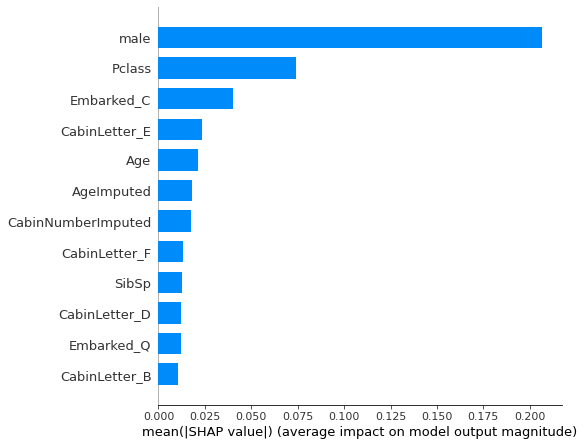

In [16]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shap_values_deep_explainer[0], 
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  plot_type='bar',
                  max_display=12,
                  show=False)
plt.tight_layout()
plt.show()

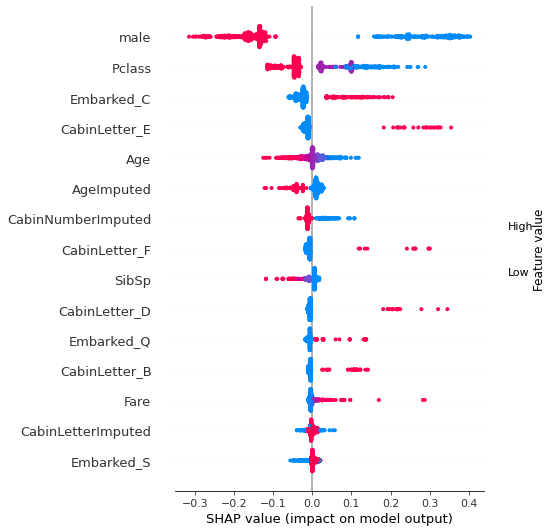

In [17]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shap_values_deep_explainer[0], 
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  plot_type='dot',
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

In [18]:
location_low_probability = np.where(y_prob_train < 0.05)[0][0]
location_high_probability = np.where(y_prob_train > 0.95)[0][0]

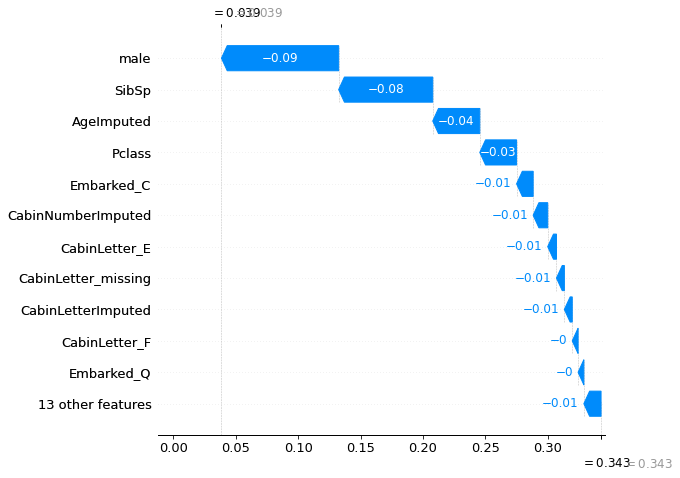

In [19]:
shap.plots._waterfall.waterfall_legacy(
    explainer_d.expected_value[0].numpy(), 
    shap_values_deep_explainer[0][location_low_probability],
    max_display=12,
    feature_names = features)

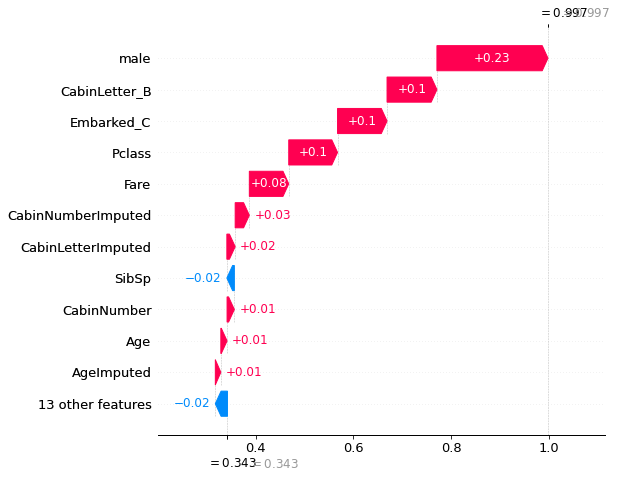

In [20]:
shap.plots._waterfall.waterfall_legacy(
    explainer_d.expected_value[0].numpy(), 
    shap_values_deep_explainer[0][location_high_probability],
    max_display=12,
    feature_names = features)

## Show relationship between feature values and Shap

`shap.plots.scatter`, as used for logistic regression and random forests, does not work with DeepExplainer for neural nets. Here we manually plot feature values and their matching Shap value.

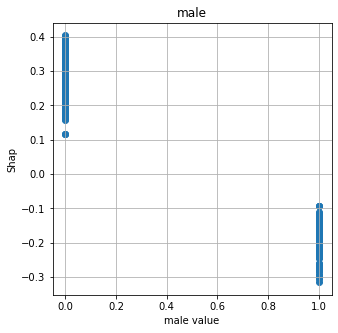

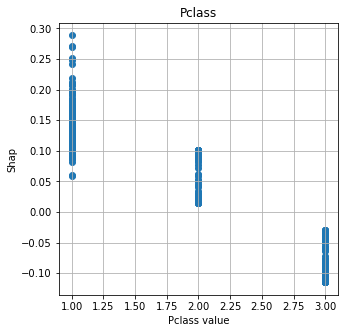

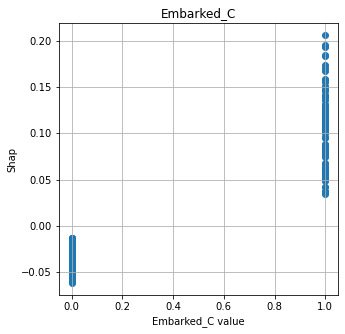

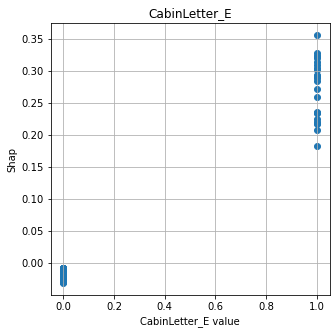

In [21]:
# Show four most influential features
feat_to_show = mean_abs_shap.index[0:4]

for feat in feat_to_show:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    x = X_train[feat]
    y = shap_df[feat]
    ax.scatter(x,y)
    ax.set_title(feat)
    ax.set_xlabel(f'{feat} value')
    ax.grid()
    ax.set_ylabel('Shap')    